## Excess Credit Research

In [0]:
import pandas as pd
import pickle
import glob
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

### 1. Read Tables
- XPrograms
- tblAwards
- tblMergeX

In [3]:
# read table XPrograms
XPrograms = pd.read_excel("XPrograms.xlsx", index_col='ID').reset_index()
print(XPrograms.columns)
XPrograms.head(1)

Index(['ID', 'Maj', 'MajName', 'ProgName', 'Prog', 'Deg', 'Div', 'Dept', 'LYr',
       'FYr', 'ProgCredits', 'Bulletin Year', 'Banner Year', 'Extra'],
      dtype='object')


,ID,Maj,MajName,ProgName,Prog,Deg,Div,Dept,LYr,FYr,ProgCredits,Bulletin Year,Banner Year,Extra
0,3448,01A1,3+1 Graphic Design- EMU (X),3+1 Graphic Design- EMU (X),TR01A1,TR,BCT,DMAD,2015.0,2013.0,94.0,2013,2014,NaN


In [4]:
# read table tblAwards
tblAwards = pd.read_excel("tblAwards.xlsx", index_col=0)
print(tblAwards.columns)
print("Total Length of tblAwards: ", tblAwards.shape)
tblAwards.head(1)

Index(['CohortTrm', 'PIDM', 'WCCID', 'A/C', 'Cons/SO', 'TermsElpsd',
       'TermsAtt', 'CumCrAtt', 'CumCrErn', 'CumCrTran', 'CrAtt/Term',
       'CrErn/Term', 'SEX', 'Eth', 'EthComputed', 'Citz', 'BDate', 'Age',
       'GradAge', 'DegC', 'Maj', 'CIP', 'Prog', 'Div', 'ProgCredits',
       'CreditGrp', 'CtlgYr', 'DegDte', 'GradAcadYr', 'FirstDeg', 'Minor',
       'Conc', 'FTrmCrAtt', 'Seq'],
      dtype='object')
Total Length of tblAwards:  (54304, 34)


,CohortTrm,PIDM,WCCID,A/C,Cons/SO,TermsElpsd,TermsAtt,CumCrAtt,CumCrErn,CumCrTran,CrAtt/Term,CrErn/Term,SEX,Eth,EthComputed,Citz,BDate,Age,GradAge,DegC,Maj,CIP,Prog,Div,ProgCredits,CreditGrp,CtlgYr,DegDte,GradAcadYr,FirstDeg,Minor,Conc,FTrmCrAtt,Seq
DownloadDte,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-09,199509,1133,@00015315,A,SO,31.0,15.0,102.0,90.0,0.0,6.8,6.0,M,W,W,Y,1962-07-09,23.0,33.0,AGS,GST,240102.0,NaN,ATP,NaN,60-75,NaN,1995-12-16,1996.0,1,NaN,NaN,198509,11.10.10111.10.00.00.11.11.11.A


In [5]:
chunk_size = 40000 #size of chunks relies on your available memory
separator = ","

# read in the data as chunks and save each chunk as pickle
reader = pd.read_csv("./tblMergeX.csv",sep=separator,chunksize=chunk_size, low_memory=False)
i=1
for chunk in reader:
    out_file = "./" + "data_{}.pkl".format(i)
    with open(out_file, "wb") as f:
        pickle.dump(chunk,f,pickle.HIGHEST_PROTOCOL)
    i+=1

# read in the pickles and append each pickle to your desired dataframe
pickle_path = "./" #Same Path as out_path i.e. where the pickle files are
data_p_files=[]
for name in glob.glob(pickle_path + "/data_*.pkl"):
    data_p_files.append(name)

tblMergeX = pd.DataFrame([])
for i in range(len(data_p_files)):
    tblMergeX = tblMergeX.append(pd.read_pickle(data_p_files[i]),ignore_index=True)
print(tblMergeX.shape)
tblMergeX.head(5)

(391284, 42)


,DownloadDte,UA,PIDM,RegTerm,BDate,Age,SEX,Eth,FTrmCrAtt,SecTrmAtt,SemCrAtt,SemCrErn,SemCrGPA,SemHonPts,SemGPA,EDLV,EGOL,Maj,Prog,CumCrAtt,CumCrErn,CumCrErnTrans,CumCrGPA,CumHonPts,CumGPA,CntTrmAtt,NextTrmAtt,NextYrAtt,PELL,SType,AdmtCd,AdmtTrm,Resid,ResdCd,RateCd,ALMT_MostRecent,ALRD_MostRecent,ALWR_MostRecent,ALMT_Initial,ALRD_Initial,ALWR_Initial,HSGPA
0,8/14/2019,0,920005,201401,12/1/1991,22.0,M,W,201309.0,1,10.0,8.0,8.0,28.0,3.5,TCC,AS,HVCR,APHVCR,3.0,0.0,NaN,0.0,0.0,NaN,2.0,1.0,1.0,1,C,ST,201309.0,I,I,NaN,1.0,6.0,6.0,1.0,6.0,6.0,NaN
1,8/14/2019,0,920005,201405,12/1/1991,22.0,M,W,201309.0,1,4.0,4.0,4.0,12.0,3.0,TCC,AS,HVCR,APHVCR,13.0,8.0,NaN,8.0,28.0,3.500000,3.0,1.0,1.0,1,C,ST,201309.0,I,I,NaN,1.0,6.0,6.0,1.0,6.0,6.0,NaN
2,8/14/2019,0,920005,201409,12/1/1991,22.0,M,W,201309.0,1,8.0,8.0,8.0,20.0,2.5,TCC,AS,HVCR,APHVCR,17.0,12.0,NaN,12.0,40.0,3.333333,4.0,1.0,0.0,1,C,ST,201309.0,I,I,NaN,1.0,6.0,6.0,1.0,6.0,6.0,NaN
3,8/14/2019,0,920005,201501,12/1/1991,23.0,M,W,201309.0,1,5.0,3.0,3.0,12.0,4.0,TCC,AS,HVCR,APHVCR,25.0,20.0,NaN,20.0,60.0,3.000000,5.0,1.0,0.0,1,C,ST,201309.0,I,I,NaN,1.0,6.0,6.0,1.0,6.0,6.0,NaN
4,8/14/2019,0,920005,201505,12/1/1991,23.0,M,W,201309.0,1,2.0,0.0,2.0,0.0,0.0,TCC,AS,HVCR,APHVCR,30.0,23.0,NaN,23.0,72.0,3.130435,6.0,0.0,0.0,1,C,ST,201309.0,I,I,NaN,1.0,6.0,6.0,1.0,6.0,6.0,NaN


### 2. Subset tblMergeX

In [6]:
# extract some race-major-course-credits info from tblMergeX to subset
tblMergeX.columns

Index(['DownloadDte', 'UA', 'PIDM', 'RegTerm', 'BDate', 'Age', 'SEX', 'Eth',
       'FTrmCrAtt', 'SecTrmAtt', 'SemCrAtt', 'SemCrErn', 'SemCrGPA',
       'SemHonPts', 'SemGPA', 'EDLV', 'EGOL', 'Maj', 'Prog', 'CumCrAtt',
       'CumCrErn', 'CumCrErnTrans', 'CumCrGPA', 'CumHonPts', 'CumGPA',
       'CntTrmAtt', 'NextTrmAtt', 'NextYrAtt', 'PELL', 'SType', 'AdmtCd',
       'AdmtTrm', 'Resid', 'ResdCd', 'RateCd', 'ALMT_MostRecent',
       'ALRD_MostRecent', 'ALWR_MostRecent', 'ALMT_Initial', 'ALRD_Initial',
       'ALWR_Initial', 'HSGPA'],
      dtype='object')

In [7]:
basicInfo = ['PIDM', 'Age', 'SEX', 'Eth']
majorInfo = ['Maj', 'Prog']

GPAInfo = ['SemGPA', 'CumGPA']
termInfo = ['RegTerm', 'FTrmCrAtt', 'CntTrmAtt']
creditInfo = ['CumCrAtt', 'CumCrErn', 'CumCrErnTrans']

TotalInfo = basicInfo + majorInfo + GPAInfo + termInfo + creditInfo
# sub_tblMergeX - contain all needed info at this point
sub_tblMergeX = tblMergeX[TotalInfo]
print(sub_tblMergeX.shape)
sub_tblMergeX.head(5)

(391284, 14)


,PIDM,Age,SEX,Eth,Maj,Prog,SemGPA,CumGPA,RegTerm,FTrmCrAtt,CntTrmAtt,CumCrAtt,CumCrErn,CumCrErnTrans
0,920005,22.0,M,W,HVCR,APHVCR,3.5,NaN,201401,201309.0,2.0,3.0,0.0,NaN
1,920005,22.0,M,W,HVCR,APHVCR,3.0,3.500000,201405,201309.0,3.0,13.0,8.0,NaN
2,920005,22.0,M,W,HVCR,APHVCR,2.5,3.333333,201409,201309.0,4.0,17.0,12.0,NaN
3,920005,23.0,M,W,HVCR,APHVCR,4.0,3.000000,201501,201309.0,5.0,25.0,20.0,NaN
4,920005,23.0,M,W,HVCR,APHVCR,0.0,3.130435,201505,201309.0,6.0,30.0,23.0,NaN


### 3. Subset tblAwards

In [8]:
# extract some race-major-course-credits info from tblAwards to subset
basicInfo_aw = ['PIDM', 'WCCID', 'A/C', 'Age', 'GradAge', 'SEX', 'Eth']
# CohortTrm - final quit
termInfo_aw = ['CohortTrm', 'FTrmCrAtt', 'TermsElpsd', 'TermsAtt', 'GradAcadYr']
majorInfo_aw = ['Maj', 'Prog']
creditInfo_aw = ['CumCrAtt', 'CumCrErn', 'CumCrTran', 'ProgCredits']

TotalInfo_aw = basicInfo_aw + termInfo_aw + majorInfo_aw + creditInfo_aw
sub_tblAwards = tblAwards[TotalInfo_aw].reset_index()
print(sub_tblAwards.shape)
sub_tblAwards.head(5)

(54304, 19)


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,CumCrAtt,CumCrErn,CumCrTran,ProgCredits
0,2019-09-09,1133,@00015315,A,23.0,33.0,M,W,199509,198509,31.0,15.0,1996.0,GST,NaN,102.0,90.0,0.0,NaN
1,2019-09-09,1318,@00015500,A,20.0,26.0,M,W,199509,199005,17.0,10.0,1996.0,CEMP,NaN,98.0,77.0,0.0,NaN
2,2019-09-09,1322,@00015504,A,18.0,20.0,M,W,199509,199305,8.0,7.0,1996.0,ROB,NaN,67.0,67.0,0.0,NaN
3,2019-09-09,1458,@00015640,A,17.0,21.0,F,W,199509,199209,10.0,8.0,1996.0,ROB,NaN,80.0,75.0,0.0,NaN
4,2019-09-09,1507,@00015689,A,27.0,49.0,M,W,199509,197309,67.0,22.0,1996.0,NURS,NaN,158.0,119.0,5.0,NaN


### 4. Missing data imputation for subset tblAwards 

### 4.1 GPA Statistics

In [9]:
# find unique number of PIDM in tblMergeX
print(len(sub_tblMergeX['PIDM'].unique()))

# chek if MergeX table contains all appears in Awards
A = list(sub_tblMergeX['PIDM'].unique())
B = list(sub_tblAwards['PIDM'].unique())
print("Number of unique PIDM in table Awards: ", len(set(B).difference(set(A))))

# filter out all certificate and check again
B = list(sub_tblAwards[sub_tblAwards['A/C'] == "A"].PIDM.unique())
print("Number of unique PIDM in table Awards: ", len(set(B).difference(set(A))))

# filter out all graduates before year 2000 and check again
B = list(sub_tblAwards[(sub_tblAwards['A/C'] == "A") & 
                       (sub_tblAwards['GradAcadYr'] >= 2000)].PIDM.unique())
print("Number of unique PIDM in table Awards: ", len(set(B).difference(set(A))))

# find unique records in tbl_Awards somehow
sub_tblAwards[sub_tblAwards["PIDM"].isin(list(set(B).difference(set(A))))].head(5)

111789
Number of unique PIDM in table Awards:  11056
Number of unique PIDM in table Awards:  8229
Number of unique PIDM in table Awards:  5862


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,CumCrAtt,CumCrErn,CumCrTran,ProgCredits
16,2019-09-09,25066,@00038811,A,25.0,35.0,M,H,199509,198605,29.0,22.0,1996.0,ROB,NaN,145.0,108.0,0.0,NaN
26,2019-09-09,39247,@00052790,A,22.0,51.0,M,W,199509,196705,86.0,15.0,1996.0,GSBU,NaN,164.0,80.0,0.0,NaN
106,2019-09-09,100864,@00113462,A,19.0,45.0,F,W,199509,196905,80.0,13.0,1996.0,GSHP,NaN,100.0,79.0,10.0,NaN
231,2019-09-09,25572,@00039309,C,18.0,24.0,M,W,199601,199009,17.0,12.0,1996.0,TOMO,NaN,60.0,52.0,0.0,NaN
361,2019-09-09,108861,@00121348,A,18.0,27.0,M,H,199601,198709,26.0,17.0,1996.0,GST,NaN,175.0,101.0,0.0,NaN


In [10]:
# find number of common PIDM in subset tblAwards and tblMergeX
temp = pd.merge(sub_tblAwards, sub_tblMergeX, how='inner', on=['PIDM'])
print("Number of Awarded students whose GPA is available: ", len(temp['PIDM'].unique()))
print("Percent: ", len(temp['PIDM'].unique())/sub_tblAwards.shape[0])

Number of Awarded students whose GPA is available:  24401
Percent:  0.4493407483794932


### 4.2 Major/Programs required credits imputation

In [11]:
sub_tblAwards = pd.merge(sub_tblAwards, XPrograms[['Maj', 'Bulletin Year', 'ProgCredits']], how='left',
                         left_on=['Maj', 'GradAcadYr'], right_on=['Maj', 'Bulletin Year'])
# set new column for credits earned from WCC
sub_tblAwards['CumCrEarnedWCC'] = sub_tblAwards['CumCrErn'] - sub_tblAwards['CumCrTran']

print(sub_tblAwards.shape)
sub_tblAwards.head(5)

(54304, 22)


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,ProgCredits_y,CumCrEarnedWCC
0,2019-09-09,1133,@00015315,A,23.0,33.0,M,W,199509,198509,31.0,15.0,1996.0,GST,NaN,102.0,90.0,0.0,NaN,1996.0,60.0,90.0
1,2019-09-09,1318,@00015500,A,20.0,26.0,M,W,199509,199005,17.0,10.0,1996.0,CEMP,NaN,98.0,77.0,0.0,NaN,1996.0,67.0,77.0
2,2019-09-09,1322,@00015504,A,18.0,20.0,M,W,199509,199305,8.0,7.0,1996.0,ROB,NaN,67.0,67.0,0.0,NaN,1996.0,67.0,67.0
3,2019-09-09,1458,@00015640,A,17.0,21.0,F,W,199509,199209,10.0,8.0,1996.0,ROB,NaN,80.0,75.0,0.0,NaN,1996.0,67.0,75.0
4,2019-09-09,1507,@00015689,A,27.0,49.0,M,W,199509,197309,67.0,22.0,1996.0,NURS,NaN,158.0,119.0,5.0,NaN,1996.0,72.0,114.0


In [12]:
# Combine ProgCredits columns from two tables
sub_tblAwards['ProgCredits_x'].fillna(sub_tblAwards['ProgCredits_y'], inplace=True)
del sub_tblAwards['ProgCredits_y']
sub_tblAwards.head(5)

,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,CumCrEarnedWCC
0,2019-09-09,1133,@00015315,A,23.0,33.0,M,W,199509,198509,31.0,15.0,1996.0,GST,NaN,102.0,90.0,0.0,60.0,1996.0,90.0
1,2019-09-09,1318,@00015500,A,20.0,26.0,M,W,199509,199005,17.0,10.0,1996.0,CEMP,NaN,98.0,77.0,0.0,67.0,1996.0,77.0
2,2019-09-09,1322,@00015504,A,18.0,20.0,M,W,199509,199305,8.0,7.0,1996.0,ROB,NaN,67.0,67.0,0.0,67.0,1996.0,67.0
3,2019-09-09,1458,@00015640,A,17.0,21.0,F,W,199509,199209,10.0,8.0,1996.0,ROB,NaN,80.0,75.0,0.0,67.0,1996.0,75.0
4,2019-09-09,1507,@00015689,A,27.0,49.0,M,W,199509,197309,67.0,22.0,1996.0,NURS,NaN,158.0,119.0,5.0,72.0,1996.0,114.0


### 4.3 Split sub_tblAwards based on duplicated PIDM

In [13]:
# filter out year before 2000 and all certificate degree 
sub_tblAwards = sub_tblAwards[(sub_tblAwards['A/C'] == "A") & 
                       (sub_tblAwards['GradAcadYr'] >= 2000)]
print(len(sub_tblAwards['PIDM'].unique()))

# play with excess credits
sub_tblAwards['ExcessCr'] = sub_tblAwards['CumCrErn'] - sub_tblAwards['ProgCredits_x']
print(sub_tblAwards[sub_tblAwards['ExcessCr'] < 0].shape)
print("Negative percent: ", sub_tblAwards[sub_tblAwards['ExcessCr'] < 0].shape[0]/sub_tblAwards.shape[0])
print(sub_tblAwards['ExcessCr'].describe())

# at this point - only work on those non-negative credits records
sub_tblAwards = sub_tblAwards[sub_tblAwards['ExcessCr'] >= 0]

19720
(413, 22)
Negative percent:  0.01915495570706368
count    20572.000000
mean        20.749441
std         18.846467
min        -53.000000
25%          7.000000
50%         17.000000
75%         29.000000
max        183.000000
Name: ExcessCr, dtype: float64


### 5. Statistics and Plotting

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import numpy as np

### 5.1 No Transfer credits - ALL from WCC

In [16]:
# filter those who has no transfer credits
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] == 0]
print("Shape of records having no transfer credits: ", temp.shape)

Shape of records having no transfer credits:  (11548, 22)


### 5.1.1 Only one Associate degree

In [17]:
# split sub_tblAwards into two tables based on the duplicity of records
temp_sig = temp.drop_duplicates('PIDM', keep=False)
print(len(temp_sig['PIDM'].unique()))

9568


#### Enrolled Term and Elapsed Term for Associate Degree

     TermsAtt  TermsElpsd
A/C                      
A        9568        9568


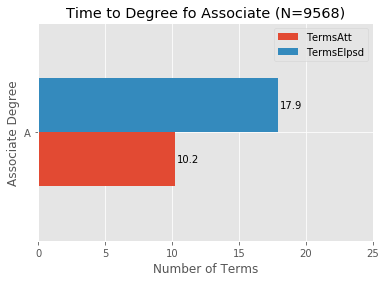

In [18]:
df = temp_sig[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").count())

# visualization
ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 25) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree fo Associate (N=9568)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
      
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F        5545        5545
    M        4023        4023


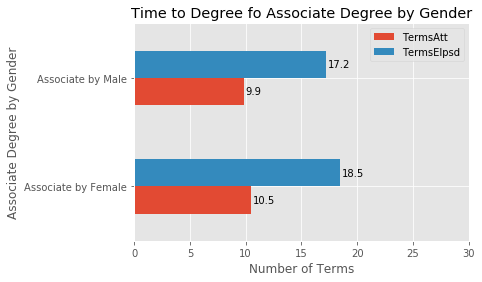

In [19]:
df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 30) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender")
ax.set_yticklabels(["Associate by Female", "Associate by Male"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()

               TermsAtt  TermsElpsd
A/C age > 20                       
A   0          9.825218   17.142796
    1         11.331384   20.143470


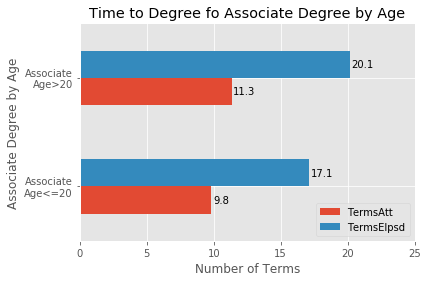

In [20]:
# add a column to tell age larger than 20 or not
temp_sig["age > 20"] = (temp_sig['Age'] > 20).astype(int)

df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "age > 20"]].groupby(["A/C", "age > 20"]).mean())

ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 25) # expand xlim
ax.set_ylabel("Associate Degree by Age")
ax.set_title("Time to Degree fo Associate Degree by Age")
ax.set_yticklabels(["Associate\nAge<=20", "Associate\nAge>20"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()


#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      6.985576
(10, 20]    10.731506
(20, 30]    13.753731
(30, 200]   15.565116


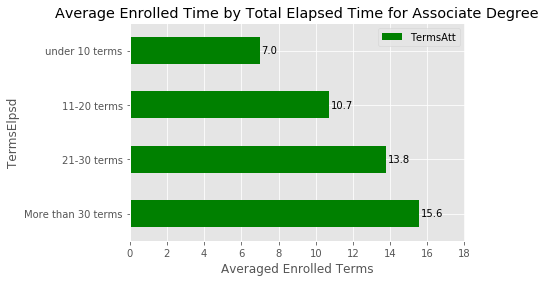

In [21]:
bins = [0, 10, 20, 30, 200]
df = temp_sig[["TermsAtt"]].groupby(pd.cut(temp_sig["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 18)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree")
# ytick
ax.set_yticklabels(["under 10 terms", "11-20 terms", "21-30 terms", "More than 30 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()


#### Statistical Table for Excess Credits

In [22]:
df = temp_sig.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)

df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,Prog,Required Credits,Num of Completers
18,AALAT,60.0,1833
77,APOST,60.0,974
0,AABAS,60.5,710
75,APNURS,69.0,475
100,ASGSMS,60.0,446


In [23]:
temp_sig = temp_sig[(~temp_sig["Prog"].isna())]

# groupby two tables for all completers and those with excess credits
df1 = temp_sig.groupby(["Prog", "Maj"]).size().reset_index(name="# Completers")
df2 = temp_sig[temp_sig["ExcessCr"]>0].groupby(["Prog", "Maj"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
18,AALAT,LAT,1833,1712,93.40%
77,APOST,OST,974,934,95.89%
0,AABAS,BAS,710,675,95.07%
75,APNURS,NURS,475,475,100.00%
100,ASGSMS,GSMS,446,441,98.88%


In [24]:
# get the statistical info - median/mean/max for credits info
temp = temp_sig[["Prog", "Maj", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["Prog", "Maj", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['Prog', 'Maj']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,Maj,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AABAS,BAS,60.0,75.5,77.359155,141.0,15.5,17.312676,81.0
1,AABCA,BCA,61.0,78.0,78.860000,99.0,17.0,17.500000,38.0
2,AACIST,CIST,62.0,82.0,83.076923,126.0,20.0,20.692308,64.0
3,AACJ,CJ,63.0,84.0,85.581181,146.0,22.0,23.507380,86.0
4,AACMG,CMG,66.0,83.0,85.738095,117.0,17.0,19.404762,51.0


In [25]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
18,AALAT,LAT,1833,1712,93.40%,60.0,69.0,71.884615,155.0,9.0,11.884615,95.0
77,APOST,OST,974,934,95.89%,60.0,74.0,75.705852,141.0,14.0,15.705852,81.0
0,AABAS,BAS,710,675,95.07%,60.0,75.5,77.359155,141.0,15.5,17.312676,81.0
75,APNURS,NURS,475,475,100.00%,72.0,101.0,103.760000,207.5,30.0,32.374737,135.5
100,ASGSMS,GSMS,446,441,98.88%,60.0,76.0,77.899103,126.0,16.0,17.899103,66.0
127,GSHS,GSHS,332,285,85.84%,60.0,66.0,69.183735,142.0,6.0,9.183735,82.0
10,AAGSLA,GSLA,289,270,93.43%,60.0,69.0,72.282007,122.0,9.0,12.282007,62.0
13,AAHUST,HUST,278,276,99.28%,61.0,80.0,81.764388,124.0,19.0,20.875899,63.0
3,AACJ,CJ,271,268,98.89%,63.0,84.0,85.581181,146.0,22.0,23.507380,86.0
7,AAELEM,ELEM,228,215,94.30%,62.0,74.0,76.561404,163.0,12.0,14.381579,101.0


### 5.1.2 More than one Associate degree

In [65]:
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] == 0]
temp_dup = temp[temp.duplicated(['PIDM'], keep=False)]
print(len(temp_dup['PIDM'].unique()))

temp_dup.head(10)

960


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,CumCrEarnedWCC,ExcessCr
2966,2019-09-09,26627,@00040348,A,19.0,35.0,F,B,199909,198409,46.0,15.0,2000.0,GSHS,GSHS,113.0,101.0,0.0,60.0,2000.0,101.0,41.0
2989,2019-09-09,65050,@00078223,A,17.0,29.0,F,B,199909,198809,34.0,14.0,2000.0,COR,COR,80.0,74.0,0.0,60.0,2000.0,74.0,14.0
3039,2019-09-09,130790,@00142968,A,28.0,35.0,M,A,199909,199301,21.0,11.0,2000.0,GSHS,GSHS,86.5,73.5,0.0,60.0,2000.0,73.5,13.5
3110,2019-09-09,168241,@00180099,A,17.0,20.0,F,W,199909,199609,10.0,9.0,2000.0,GDTD,GDTD,74.0,71.0,0.0,63.0,2000.0,71.0,8.0
3129,2019-09-09,177786,@00189571,A,41.0,44.0,M,W,199909,199705,8.0,6.0,2000.0,GDTD,GDTD,67.0,67.0,0.0,65.0,2000.0,67.0,2.0
3281,2019-09-09,130790,@00142968,A,28.0,36.0,M,A,200001,199301,22.0,12.0,2000.0,RTH,RTH,94.5,79.5,0.0,76.0,2000.0,79.5,3.5
3287,2019-09-09,135527,@00147653,A,19.0,25.0,M,W,200001,199309,20.0,16.0,2000.0,GDTD,GDTD,111.0,107.0,0.0,63.0,2000.0,107.0,44.0
3288,2019-09-09,135527,@00147653,A,19.0,25.0,M,W,200001,199309,20.0,16.0,2000.0,GDTI,GDTI,111.0,107.0,0.0,70.0,2000.0,107.0,37.0
3332,2019-09-09,158682,@00170622,A,19.0,23.0,M,B,200001,199509,14.0,13.0,2000.0,ABRD,ABRD,130.0,83.0,0.0,63.0,NaN,83.0,20.0
3341,2019-09-09,161961,@00173861,A,18.0,22.0,F,W,200001,199601,13.0,12.0,2000.0,GSBU,GSBU,98.0,85.0,0.0,60.0,2000.0,85.0,25.0


#### Enrolled Term and Elapsed Term for Associate Degree

     TermsAtt  TermsElpsd
A/C                      
A        1980        1980


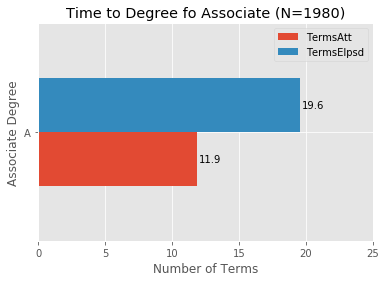

In [66]:
df = temp_dup[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").count())

# visualization
ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 25) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree fo Associate (N=1980)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
      
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F        1207        1207
    M         773         773


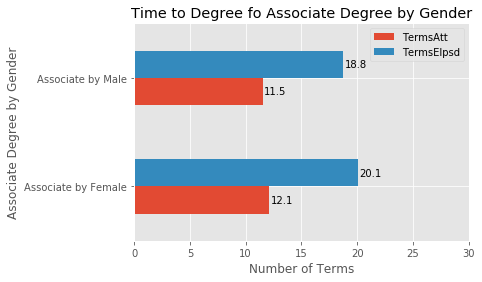

In [67]:
df = temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 30) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender")
ax.set_yticklabels(["Associate by Female", "Associate by Male"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()

#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      7.585903
(10, 20]    11.652531
(20, 30]    14.921260
(30, 200]   19.181529


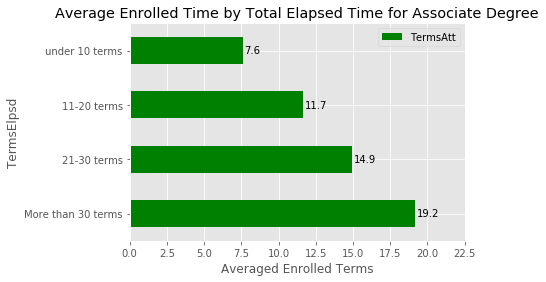

In [68]:
bins = [0, 10, 20, 30, 200]
df = temp_dup[["TermsAtt"]].groupby(pd.cut(temp_dup["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 22.5)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree")
# ytick
ax.set_yticklabels(["under 10 terms", "11-20 terms", "21-30 terms", "More than 30 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()

#### Statistical Table for Excess Credits

In [69]:
df = temp_dup.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)

df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,Prog,Required Credits,Num of Completers
75,APOST,60.0,375
16,AALAT,60.0,318
95,ASGSMS,60.0,135
73,APNURS,69.0,127
0,AABAS,60.5,125


In [70]:
temp_dup = temp_dup[(~temp_dup["Prog"].isna())]
# groupby two tables for all completers and those with excess credits
df1 = temp_dup.groupby(["Prog", "Maj"]).size().reset_index(name="# Completers")
df2 = temp_dup[temp_dup["ExcessCr"]>0].groupby(["Prog", "Maj"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
75,APOST,OST,375,373,99.47%
16,AALAT,LAT,318,311,97.80%
95,ASGSMS,GSMS,135,135,100.00%
73,APNURS,NURS,127,127,100.00%
0,AABAS,BAS,125,123,98.40%


In [71]:
# get the statistical info - median/mean/max for credits info
temp = temp_dup[["Prog", "Maj", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["Prog", "Maj", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['Prog', 'Maj']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,Maj,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AABAS,BAS,60.0,91.00,92.680000,150.0,31.00,32.672000,90.0
1,AABCA,BCA,61.0,88.75,89.583333,116.0,27.75,28.083333,55.0
2,AACIST,CIST,63.0,105.50,105.500000,114.0,42.50,42.500000,51.0
3,AACJ,CJ,63.0,95.00,96.897727,145.0,31.00,34.715909,82.0
4,AACMG,CMG,66.0,105.00,121.785714,222.0,36.00,56.214286,156.0


In [72]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
75,APOST,OST,375,373,99.47%,60.0,88.5,91.532000,155.0,28.5,31.532000,95.0
16,AALAT,LAT,318,311,97.80%,60.0,83.0,84.948113,160.0,23.0,24.948113,100.0
95,ASGSMS,GSMS,135,135,100.00%,60.0,84.0,87.485185,155.0,24.0,27.485185,95.0
73,APNURS,NURS,127,127,100.00%,72.0,118.5,120.996063,188.5,47.0,49.633858,116.5
0,AABAS,BAS,125,123,98.40%,60.0,91.0,92.680000,150.0,31.0,32.672000,90.0
96,ASHPP,HPP,49,49,100.00%,60.0,85.0,90.326531,167.0,25.0,30.326531,107.0
3,AACJ,CJ,44,44,100.00%,63.0,95.0,96.897727,145.0,31.0,34.715909,82.0
58,APGSAS,GSAS,43,43,100.00%,60.0,81.0,82.604651,106.0,21.0,22.604651,46.0
13,AAHUST,HUST,39,39,100.00%,61.0,92.0,95.705128,149.0,32.0,34.910256,88.0
10,AAGSLA,GSLA,35,35,100.00%,60.0,83.0,85.928571,155.0,23.0,25.928571,95.0


### 5.2 With Transfer credits - ALL from WCC

In [73]:
# filter those who has no transfer credits
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] > 0]
temp['transfer_percent'] = temp['CumCrTran']/temp['CumCrErn']
print("Shape of records having no transfer credits: ", temp.shape)

Shape of records having no transfer credits:  (8611, 23)


In [74]:
# check the percentage of tranferred credits
temp['transfer_percent'].describe()

count    8611.000000
mean        0.288641
std         0.202849
min         0.007168
25%         0.116883
50%         0.253521
75%         0.424528
max         0.956522
Name: transfer_percent, dtype: float64

### 5.2.1 Only one Associate degree

In [75]:
temp_sig = temp.drop_duplicates('PIDM', keep=False)
print(len(temp_sig['PIDM'].unique()))

7337


#### Enrolled Term and Elapsed Term for Associate Degree

     TermsAtt  TermsElpsd
A/C                      
A        7337        7337


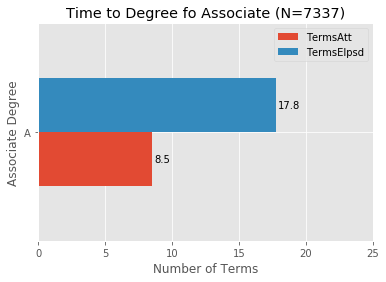

In [76]:
df = temp_sig[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").count())

# visualization
ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 25) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree fo Associate (N=7337)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
      
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F        4214        4214
    M        3123        3123


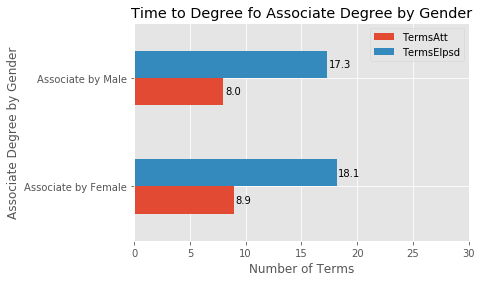

In [77]:
df = temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_sig[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 30) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender")
ax.set_yticklabels(["Associate by Female", "Associate by Male"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()

#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      5.755191
(10, 20]     9.255968
(20, 30]    11.015287
(30, 200]   13.658514


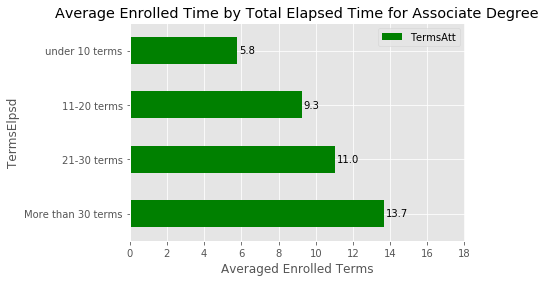

In [78]:
bins = [0, 10, 20, 30, 200]
df = temp_sig[["TermsAtt"]].groupby(pd.cut(temp_sig["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 18)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree")
# ytick
ax.set_yticklabels(["under 10 terms", "11-20 terms", "21-30 terms", "More than 30 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()


#### Statistical Table for Excess Credits

In [0]:
df = temp_sig.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)
df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()

In [80]:
temp_sig = temp_sig[(~temp_sig["Prog"].isna())]

# groupby two tables for all completers and those with excess credits
df1 = temp_sig.groupby(["Prog", "Maj"]).size().reset_index(name="# Completers")
df2 = temp_sig[temp_sig["ExcessCr"]>0].groupby(["Prog", "Maj"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
17,AALAT,LAT,836,771.0,92.22%
83,APOST,OST,713,678.0,95.09%
81,APNURS,NURS,662,662.0,100.00%
0,AABAS,BAS,466,454.0,97.42%
68,APITRN,ITRN,307,250.0,81.43%


In [81]:
# get the statistical info - median/mean/max for credits info
temp = temp_sig[["Prog", "Maj", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["Prog", "Maj", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['Prog', 'Maj']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,Maj,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AABAS,BAS,60.0,75.0,77.379828,135.0,15.00,17.341202,75.0
1,AABCA,BCA,61.0,79.5,78.475000,98.0,17.25,16.575000,37.0
2,AACIST,CIST,62.0,75.0,88.727273,148.0,12.00,26.363636,86.0
3,AACJ,CJ,63.0,86.0,88.003968,124.0,23.00,25.535714,59.0
4,AACMG,CMG,66.0,80.5,85.666667,118.0,13.00,18.916667,52.0


In [82]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
17,AALAT,LAT,836,771.0,92.22%,60.0,69.00,72.497608,149.0,9.0,12.497608,89.0
83,APOST,OST,713,678.0,95.09%,60.0,71.00,76.522440,243.0,11.0,16.522440,183.0
81,APNURS,NURS,662,662.0,100.00%,72.0,99.75,104.546073,218.5,28.0,33.082326,146.5
0,AABAS,BAS,466,454.0,97.42%,60.0,75.00,77.379828,135.0,15.0,17.341202,75.0
68,APITRN,ITRN,307,250.0,81.43%,60.0,63.00,65.493485,129.0,3.0,5.522801,69.0
141,GSHS,GSHS,225,181.0,80.44%,60.0,63.00,66.742222,115.0,3.0,6.742222,55.0
88,APRAD,RAD,207,197.0,95.17%,71.0,87.00,92.260870,160.0,18.0,21.574879,91.0
155,NURS,NURS,189,188.0,99.47%,72.0,91.00,97.820106,196.0,19.0,26.269841,125.0
9,AAGSLA,GSLA,161,149.0,92.55%,60.0,68.00,71.177019,140.0,8.0,11.177019,80.0
110,ASGSMS,GSMS,154,143.0,92.86%,60.0,75.00,77.821429,144.5,15.0,17.821429,84.5


### 5.2.2 More than one Associate degree

In [94]:
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] > 0]
temp_dup = temp[temp.duplicated(['PIDM'], keep=False)]
print(len(temp_dup['PIDM'].unique()))

temp_dup.head(10)

611


,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,CumCrEarnedWCC,ExcessCr
2972,2019-09-09,42724,@00056208,A,20.0,40.0,F,B,199909,197905,62.0,12.0,2000.0,GSHS,GSHS,123.0,67.0,16.0,60.0,2000.0,51.0,7.0
3107,2019-09-09,167821,@00179679,A,21.0,24.0,M,W,199909,199609,10.0,8.0,2000.0,GSHS,GSHS,71.0,102.0,34.0,60.0,2000.0,68.0,42.0
3113,2019-09-09,168806,@00180658,A,30.0,33.0,F,W,199909,199609,10.0,7.0,2000.0,GST,GST,52.0,101.0,49.0,60.0,2000.0,52.0,41.0
3163,2019-09-09,187609,@00199334,A,19.0,21.0,F,X,199909,199805,5.0,5.0,2000.0,CUL,CUL,60.0,78.0,18.0,69.0,NaN,60.0,9.0
3299,2019-09-09,140399,@00152489,A,19.0,24.0,F,B,200001,199501,16.0,11.0,2000.0,GSHS,GSHS,95.0,66.0,11.0,60.0,2000.0,55.0,6.0
3300,2019-09-09,141433,@00153513,A,19.0,41.0,F,W,200001,197709,68.0,10.0,2000.0,GSHP,GSHP,50.0,75.0,25.0,60.0,2000.0,50.0,15.0
3303,2019-09-09,142865,@00154929,A,35.0,37.0,M,W,200001,199809,5.0,5.0,2000.0,PHOT,PHOT,53.0,69.0,16.0,66.0,2000.0,53.0,3.0
3350,2019-09-09,167821,@00179679,A,21.0,24.0,M,W,200001,199609,11.0,9.0,2000.0,CUL,CUL,79.0,107.0,34.0,69.0,NaN,73.0,38.0
3361,2019-09-09,168806,@00180658,A,30.0,33.0,F,W,200001,199609,11.0,8.0,2000.0,GDTD,GDTD,56.0,105.0,49.0,65.0,2000.0,56.0,40.0
3376,2019-09-09,173540,@00185351,A,31.0,35.0,F,W,200001,199701,10.0,8.0,2000.0,JPI,JPI,40.0,69.0,29.0,60.0,NaN,40.0,9.0


#### Enrolled Term and Elapsed Term for Associate Degree

     TermsAtt  TermsElpsd
A/C                      
A        1274        1274


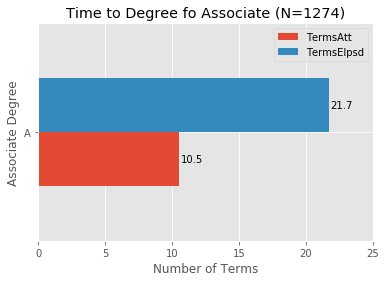

In [95]:
df = temp_dup[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "A/C"]].groupby("A/C").count())

# visualization
ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 25) # expand xlim
ax.set_ylabel("Associate Degree")
ax.set_title("Time to Degree fo Associate (N=1274)")

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 1.5
    # Vertical alignment for positive values
    ha = 'left'
    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'
    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)
    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.
      
plt.show()

#### Enrolled Term and Elapsed Term for Associate Degree by Age/Gender

         TermsAtt  TermsElpsd
A/C SEX                      
A   F         686         686
    M         588         588


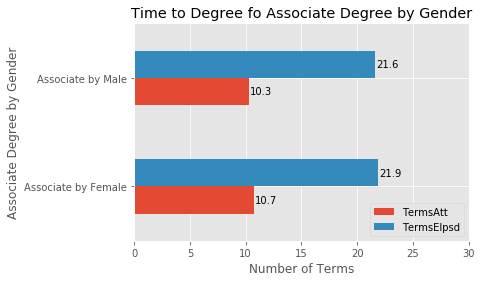

In [96]:
df = temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).mean()
print(temp_dup[["TermsAtt", "TermsElpsd", "A/C", "SEX"]].groupby(["A/C", "SEX"]).count())

ax = df.plot.barh()
ax.set_xlabel("Number of Terms")
ax.set_xlim(0, 30) # expand xlim
ax.set_ylabel("Associate Degree by Gender")
ax.set_title("Time to Degree fo Associate Degree by Gender")
ax.set_yticklabels(["Associate by Female", "Associate by Male"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 1.5
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()

#### Enrolled Term by Elapsed Term for Associate Degree

             TermsAtt
TermsElpsd           
(0, 10]      6.355844
(10, 20]    10.342282
(20, 30]    13.392857
(30, 200]   14.901460


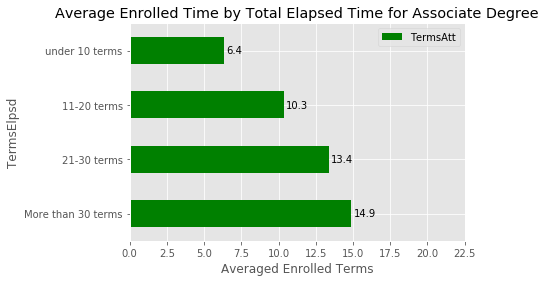

In [97]:
bins = [0, 10, 20, 30, 200]
df = temp_dup[["TermsAtt"]].groupby(pd.cut(temp_dup["TermsElpsd"], bins=bins))
print(df.mean())

ax = df.mean().plot.barh(color="green")
ax.invert_yaxis()
ax.set_xlabel("Averaged Enrolled Terms")
ax.set_xlim(0, 22.5)            
ax.set_title("Average Enrolled Time by Total Elapsed Time for Associate Degree")
# ytick
ax.set_yticklabels(["under 10 terms", "11-20 terms", "21-30 terms", "More than 30 terms"])

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'
    if x_value < 0:
        space *= -1
        ha = 'right'
    label = "{:.1f}".format(x_value)
    plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", 
                 va='center', ha=ha)                      
plt.show()

#### Statistical Table for Excess Credits

In [98]:
df = temp_dup.groupby(["Prog", "ProgCredits_x"]).size().reset_index(name="# Completers")
# aggregate information
aggregation_functions = {'ProgCredits_x': 'mean', '# Completers': 'sum'}
df = df.groupby(df['Prog']).aggregate(aggregation_functions)

df = df.rename(columns={"Prog": "Programs", "ProgCredits_x": "Required Credits", "# Completers": "Num of Completers"}).reset_index()
df.sort_values(by=['Num of Completers'], ascending=False).head(5)

,Prog,Required Credits,Num of Completers
68,APOST,60.0,225
16,AALAT,60.0,153
0,AABAS,60.5,105
66,APNURS,69.0,76
23,APACCT,65.0,36


In [99]:
temp_dup = temp_dup[(~temp_dup["Prog"].isna())]
# groupby two tables for all completers and those with excess credits
df1 = temp_dup.groupby(["Prog", "Maj"]).size().reset_index(name="# Completers")
df2 = temp_dup[temp_dup["ExcessCr"]>0].groupby(["Prog", "Maj"]).size().reset_index(name="# Completers with Excess Credits")
df = pd.merge(df1, df2,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])

# calculate the percent of those with excess credits
df['Share of Completers with Excess Credits'] = df["# Completers with Excess Credits"]/df["# Completers"]
df['Share of Completers with Excess Credits'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['Share of Completers with Excess Credits']], index = df.index)
df.sort_values(by=['# Completers'], ascending=False).head(5)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits
68,APOST,OST,225,225,100.00%
16,AALAT,LAT,153,152,99.35%
0,AABAS,BAS,105,105,100.00%
66,APNURS,NURS,76,76,100.00%
23,APACCT,ACCT,36,36,100.00%


In [100]:
# get the statistical info - median/mean/max for credits info
temp = temp_dup[["Prog", "Maj", "ProgCredits_x", "CumCrErn", "CumCrErn", "CumCrErn", 'ExcessCr', 'ExcessCr', 'ExcessCr']]
temp.columns = ["Prog", "Maj", "ProgCredits_x", "CumCrErn_median", "CumCrErn_mean", 
                "CumCrErn_max", 'ExcessCr_median', 'ExcessCr_mean', 'ExcessCr_max']
aggregation_functions = {"ProgCredits_x": 'median', "CumCrErn_median": 'median', "CumCrErn_mean": 'mean',
                         "CumCrErn_max": 'max', "ExcessCr_median": 'median', "ExcessCr_mean": 'mean', "ExcessCr_max": 'max'}
temp = temp.groupby(['Prog', 'Maj']).aggregate(aggregation_functions).reset_index()
temp.head(5)

,Prog,Maj,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
0,AABAS,BAS,60.0,92.5,95.480952,152.0,32.5,35.404762,92.0
1,AABCA,BCA,61.0,107.0,107.000000,107.0,46.0,46.000000,46.0
2,AACIST,CIST,63.0,117.0,117.000000,117.0,54.0,54.000000,54.0
3,AACJ,CJ,63.0,97.5,99.780000,127.0,36.0,37.460000,64.0
4,AACMG,CMG,66.0,94.0,103.375000,145.0,28.0,37.375000,79.0


In [101]:
# Merge table
excessCredits_table = pd.merge(df, temp,  how='left', left_on=["Prog", "Maj"], right_on = ["Prog", "Maj"])
excessCredits_table.sort_values(by=['# Completers'], ascending=False).head(10)

,Prog,Maj,# Completers,# Completers with Excess Credits,Share of Completers with Excess Credits,ProgCredits_x,CumCrErn_median,CumCrErn_mean,CumCrErn_max,ExcessCr_median,ExcessCr_mean,ExcessCr_max
68,APOST,OST,225,225,100.00%,60.0,89.0,93.508889,177.0,29.00,33.508889,117.0
16,AALAT,LAT,153,152,99.35%,60.0,90.0,94.467320,173.0,30.00,34.467320,113.0
0,AABAS,BAS,105,105,100.00%,60.0,92.5,95.480952,152.0,32.50,35.404762,92.0
66,APNURS,NURS,76,76,100.00%,72.0,125.5,126.322368,192.5,54.50,54.953947,120.5
23,APACCT,ACCT,36,36,100.00%,65.0,98.5,103.041667,158.0,33.50,38.041667,93.0
88,ASGSMS,GSMS,35,34,97.14%,60.0,105.0,105.085714,161.0,45.00,45.085714,101.0
89,ASHPP,HPP,34,32,94.12%,60.0,83.0,86.852941,146.0,23.00,26.852941,86.0
41,APCNTM,CNTM,32,32,100.00%,60.0,103.5,106.453125,177.0,42.00,45.859375,118.0
59,APITRN,ITRN,32,32,100.00%,60.0,76.5,80.328125,108.0,16.75,20.359375,48.0
40,APCNSP,CNSP,29,29,100.00%,60.0,81.0,84.017241,149.0,21.00,24.189655,89.0


### 6.Credits distributions for the Top Associate degree programs

In [108]:
temp = sub_tblAwards[sub_tblAwards["CumCrTran"] > 0]
temp_dup = temp[temp.duplicated(['PIDM'], keep=False)]
temp_dup.head(5)

,DownloadDte,PIDM,WCCID,A/C,Age,GradAge,SEX,Eth,CohortTrm,FTrmCrAtt,TermsElpsd,TermsAtt,GradAcadYr,Maj,Prog,CumCrAtt,CumCrErn,CumCrTran,ProgCredits_x,Bulletin Year,CumCrEarnedWCC,ExcessCr
2972,2019-09-09,42724,@00056208,A,20.0,40.0,F,B,199909,197905,62.0,12.0,2000.0,GSHS,GSHS,123.0,67.0,16.0,60.0,2000.0,51.0,7.0
3107,2019-09-09,167821,@00179679,A,21.0,24.0,M,W,199909,199609,10.0,8.0,2000.0,GSHS,GSHS,71.0,102.0,34.0,60.0,2000.0,68.0,42.0
3113,2019-09-09,168806,@00180658,A,30.0,33.0,F,W,199909,199609,10.0,7.0,2000.0,GST,GST,52.0,101.0,49.0,60.0,2000.0,52.0,41.0
3163,2019-09-09,187609,@00199334,A,19.0,21.0,F,X,199909,199805,5.0,5.0,2000.0,CUL,CUL,60.0,78.0,18.0,69.0,NaN,60.0,9.0
3299,2019-09-09,140399,@00152489,A,19.0,24.0,F,B,200001,199501,16.0,11.0,2000.0,GSHS,GSHS,95.0,66.0,11.0,60.0,2000.0,55.0,6.0


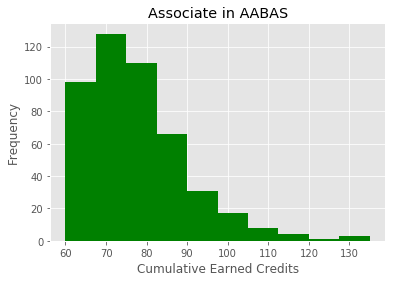

In [114]:
# fig, axs = plt.subplots(2, 2) if multiple needed
def histogramPlot(dataset_, progName):
  ax = dataset_[dataset_['Prog'] == progName].hist(column='CumCrErn',color='green')
  ax[0][0].set_xlabel("Cumulative Earned Credits")
  ax[0][0].set_ylabel("Frequency")
  ax[0][0].set_title("Associate in " + progName)
  plt.show()

histogramPlot(temp_sig, "AABAS")

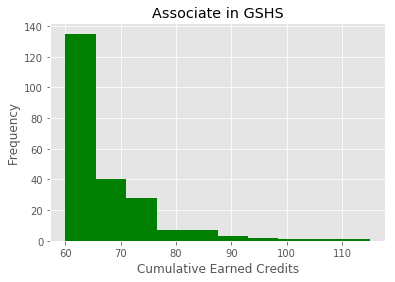

In [115]:
histogramPlot(temp_sig, "GSHS")